In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

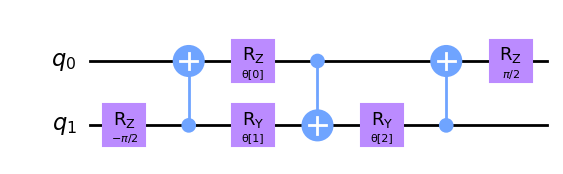

In [2]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

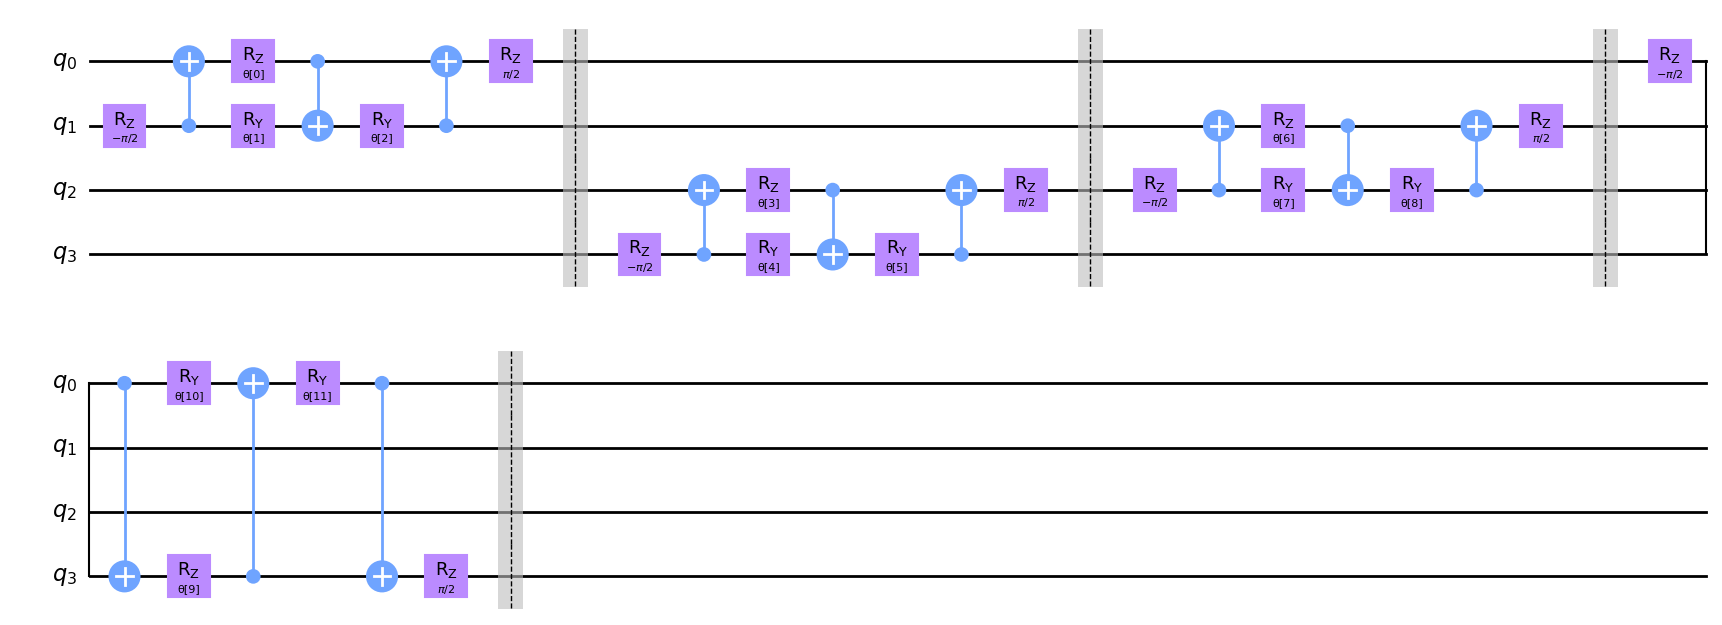

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

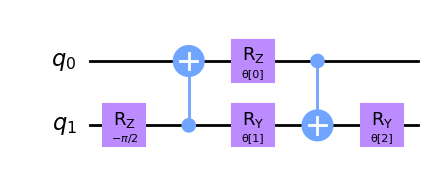

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

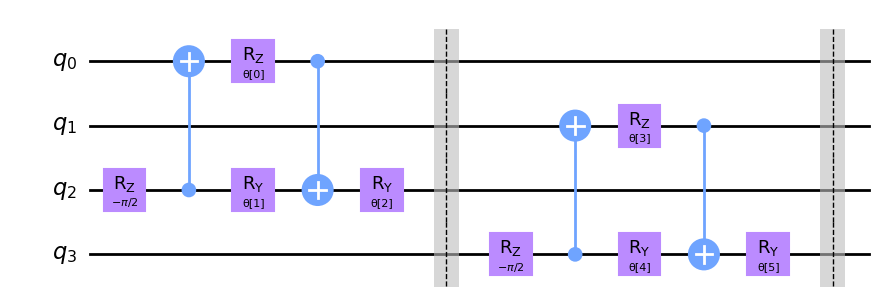

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [6]:
import os
from PIL import Image
import numpy as np

# Path to the train and test folders
train_path = 'spectograph_quantum/music'
test_path = 'spectograph_quantum/music_test'

# Load train images and labels
train_images = []
train_labels = []
for class_folder in os.listdir(train_path):
    class_path = os.path.join(train_path, class_folder)
    if os.path.isdir(class_path):
        label = int(class_folder)  # Assuming folder names are integers representing class labels
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = Image.open(image_path)
            image_array = np.asarray(image)
            train_images.append(image_array)
            train_labels.append(label)

# Load test images and labels
test_images = []
test_labels = []
for class_folder in os.listdir(test_path):
    class_path = os.path.join(test_path, class_folder)
    if os.path.isdir(class_path):
        label = int(class_folder)  # Assuming folder names are integers representing class labels
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = Image.open(image_path)
            image_array = np.asarray(image)
            test_images.append(image_array)
            test_labels.append(label)
            
            
# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
print(train_images.shape)
print(type(train_labels))

(160, 288, 432, 4)
<class 'numpy.ndarray'>


In [8]:
from sklearn.decomposition import PCA
import numpy as np

In [9]:
def min_max_scaling(x, new_min, new_max):
    x_min, x_max = x.min(), x.max()
    return (x - x_min) / (x_max - x_min) * (new_max - new_min) + new_min

In [10]:
import numpy as np

# Assuming train_images and test_images are loaded correctly
# Adjust the shape of the images accordingly

# Assuming train_labels and test_labels are loaded correctly
# Adjust accordingly if your labels are named differently

# Check the shape of train_images to understand its structure
print(train_images.shape)

# Reshape images to be suitable for PCA
x_train = np.float32(train_images.reshape(-1, train_images.shape[1] * train_images.shape[2])) / 255.
y_train = train_labels

x_test = np.float32(test_images.reshape(-1, test_images.shape[1] * test_images.shape[2])) / 255.
y_test = test_labels

# Perform PCA
n_components = 8
pca = PCA(n_components)

x_train = pca.fit_transform(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

x_test = pca.transform(x_test)
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on test :", cumsum)

# Perform min-max scaling
x_train = min_max_scaling(x_train, 0, 2 * np.pi)
x_test = min_max_scaling(x_test, 0, 2 * np.pi)


(160, 288, 432, 4)


Cumulative sum on train : 92.50279
Cumulative sum on test : 92.50279


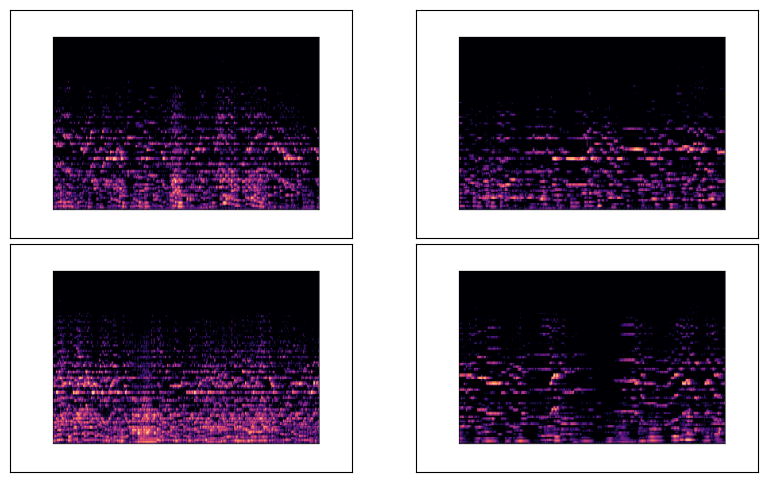

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i],
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [12]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

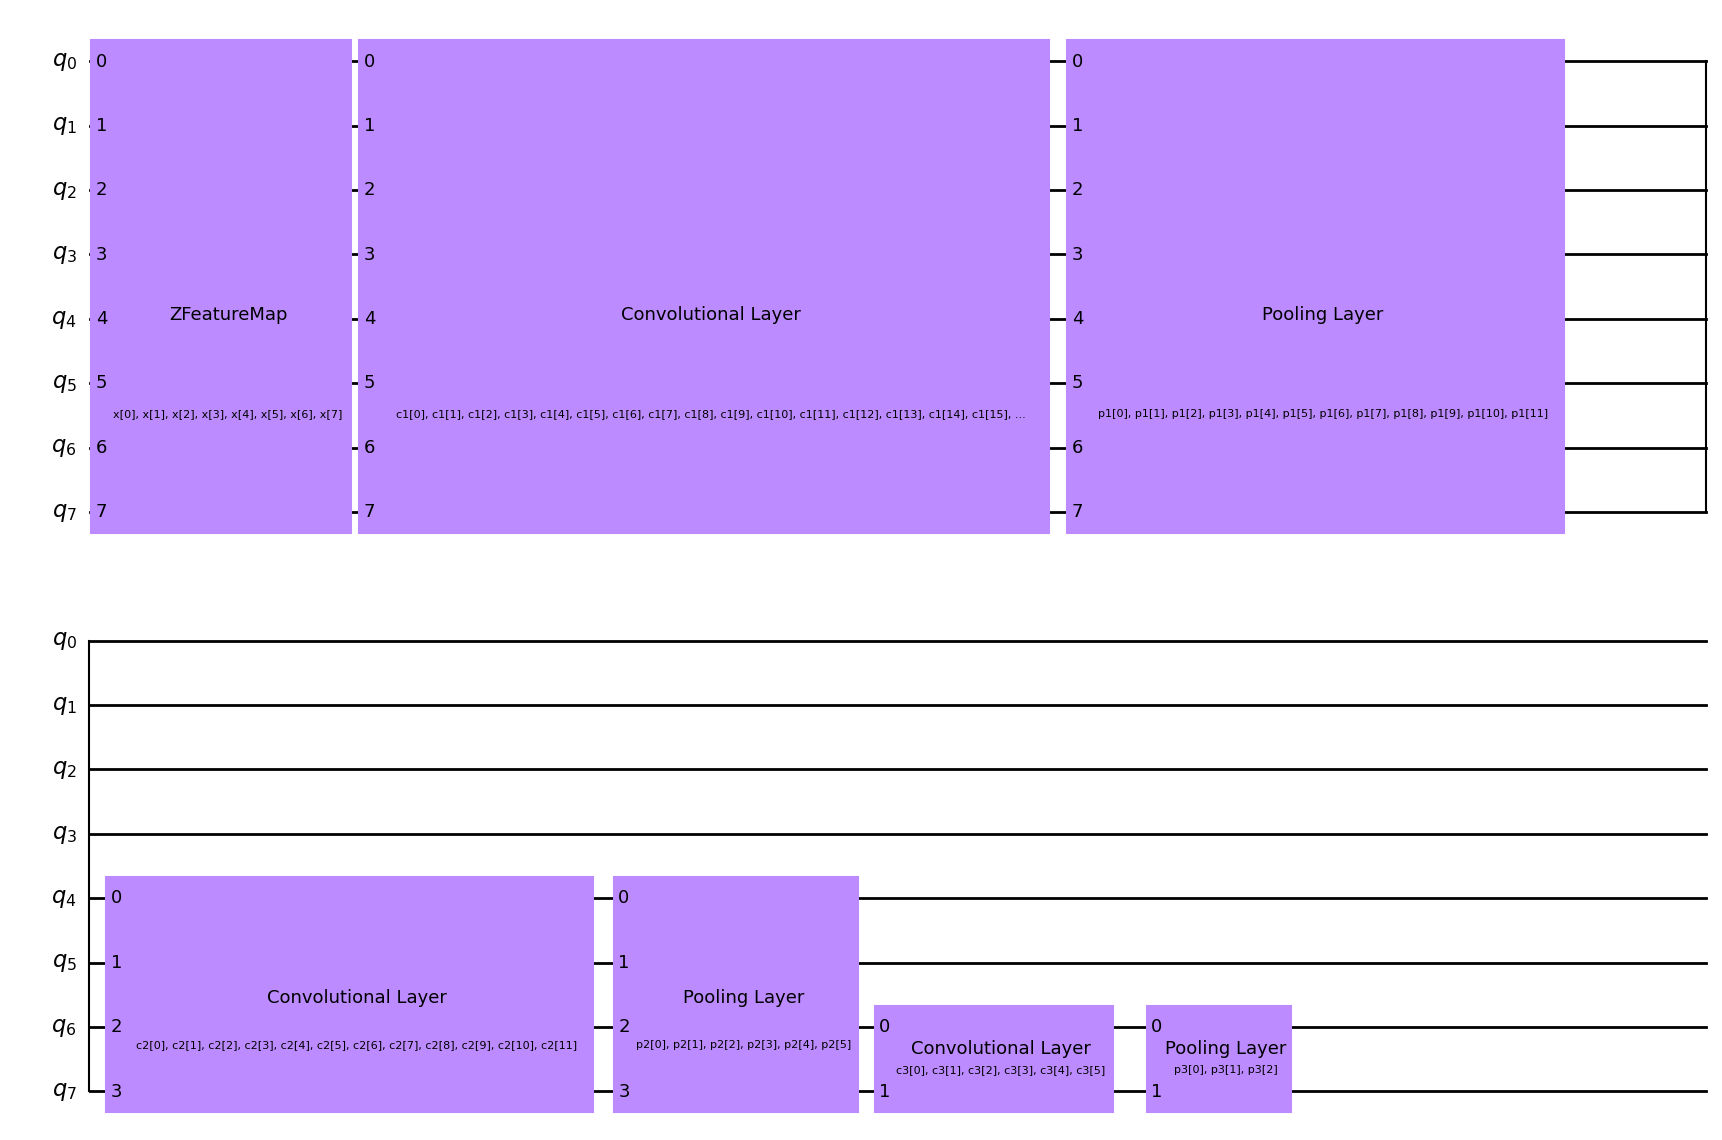

In [13]:
circuit.draw("mpl", style="clifford")

In [14]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [15]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=1),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

In [16]:
x = np.asarray(x_train)
y = np.asarray(y_train)
x_reshaped = train_images.reshape((x_train.shape[0], -1, 8))

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x_reshaped, y)

In [ ]:
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x_reshaped, y), 2)}%")

Accuracy from the test data : 66.67%


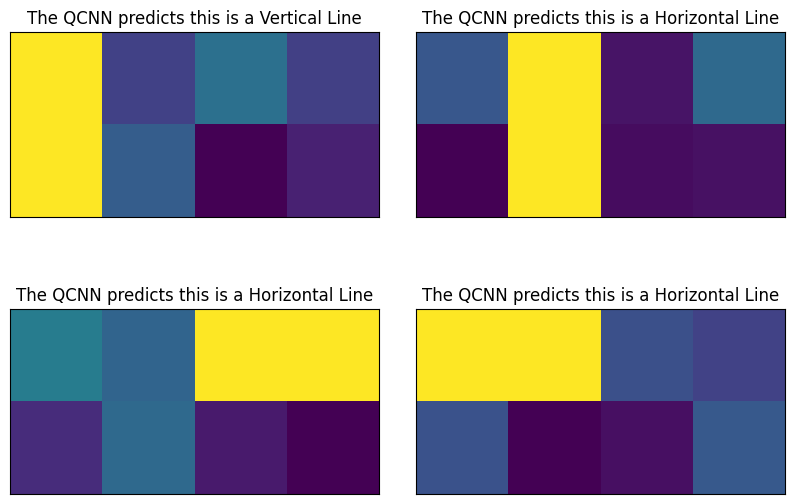

In [ ]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)